# Import Packages and functions

C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\FunctionsAndClass.py:12: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


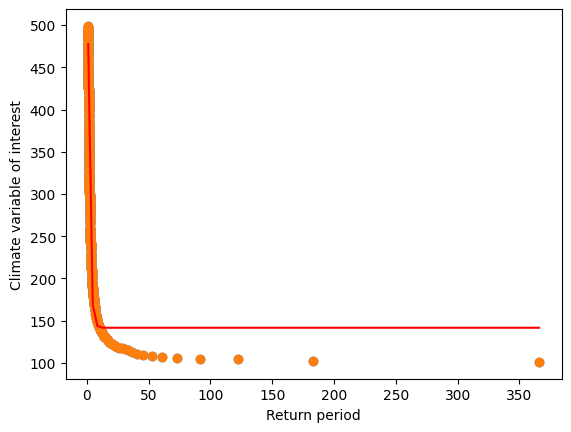

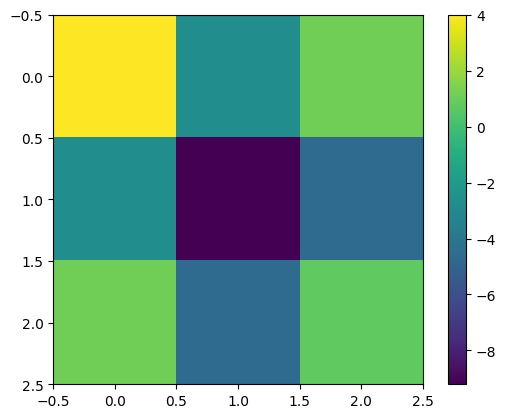

In [1]:
import requests
import pandas as pd

import os
import os.path

from netCDF4 import Dataset


import numpy as np
import numpy.ma as ma

# to measure elapsed time
import time
from timeit import default_timer as timer

import multiprocessing as mp# to download several file in parrallel
from multiprocessing.pool import ThreadPool

from FileManagement1 import produce_name_list
from FunctionsAndClass import year_copernicus
from FileManagement1 import find_path_file
from FileManagement1 import find_column_name
from FileManagement1 import data_information
from FileManagement1 import df_to_csv
from FileManagement1 import read_nc_file
from FileManagement1 import information_files_in_vectors
from FileManagement1 import create_empty_dataframe
from FileManagement1 import time_lat_lon
from FileManagement1 import register_data_in_dataframe
from FileManagement1 import closest_lat_lon_to_proj

# Projects information


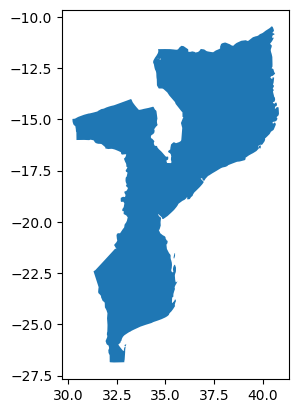

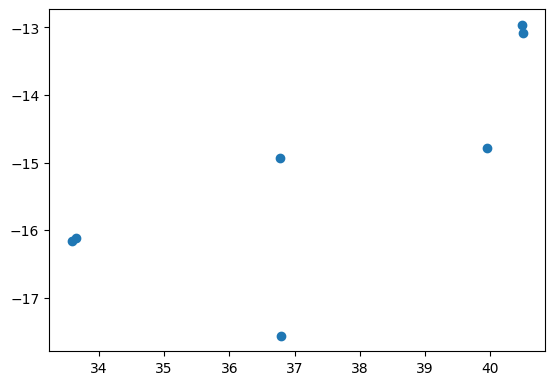

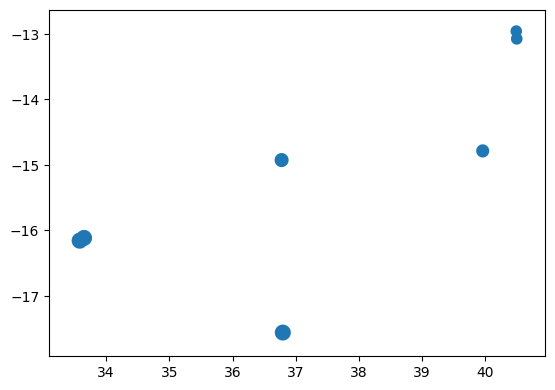

In [2]:
import geopandas as gpd
import os
import os.path

data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')


#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)

#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
project_id='Name' #name of column used as id

study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 


#show table
projects[[project_id]]
# prepare name_project for use 
name_project = projects['Name'].str.replace(' ','_') # take off every blank space of project names
name_project = name_project.str.replace('(','') # take off every ( of project names
name_project = name_project.str.replace(')','') # take off every ) of project names
name_project = name_project.str.replace('-','') # take off every - of project names
name_project = name_project.str.replace('/','_') # take off every / of project names
name_project = name_project.str.replace(r'"\"','_') # take off every \ of project names

# register geographic information concerning projects
lon_projects = projects['geometry'].x
lat_projects = projects['geometry'].y
buf_projects = 0.3
area_projects = [lat_projects - buf_projects, lat_projects+buf_projects, lon_projects-buf_projects,lon_projects+buf_projects] # list format
#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

# Define Paths

In [3]:
out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6'

# Complete list of url with files to download

In [4]:
# register information from csv file
#all_urls = pd.read_csv(r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\NEX-GDDP-CMIP6\gddp-cmip6-thredds-fileserver.csv')
csv_path = os.path.join(out_path,'gddp-cmip6-thredds-fileserver.csv')
all_urls = pd.read_csv(csv_path)

In [5]:
### make all elements of the csv into a readable list

temp_list = all_urls[[' fileUrl']].T# transpose csv
temp_list=temp_list.values.tolist()
temp_list=temp_list[0]
url_list=[s.replace(' ', '') for s in temp_list]

In [6]:
## download only precipitation data
# select only precipitation files, between 2040 and 2080
url_list_precipitation = [url for url in url_list if 'pr_day_' in url and int(url[len(url)-7:len(url)-3])>2020 and int(url[len(url)-7:len(url)-3])<2061 and 'r1i1p1f1_gn' in url]

In [7]:
len(url_list_precipitation)

2360

In [8]:
name_list_precipitation = produce_name_list(url_list_precipitation)

# Produce csv files with data to use

In [9]:
# period of interest
(year, year_str, index_year) = year_copernicus(2021,2060)

In [10]:
# variables, time_aggregations,models,scenarios in the name_list_precipitation
(variables, time_aggregations,models,scenarios)=information_files_in_vectors(name_list_precipitation)

In [11]:
path_test1 = os.path.join(out_path,'pr_day_TaiESM1_ssp370_r1i1p1f1_gn_2050.nc')

In [12]:
(time, index_closest_lat,index_closest_lon,closest_value_lat,closest_value_lon)=time_lat_lon(path_test1,lat_projects,lon_projects)

In [13]:
df_precipitation=create_empty_dataframe(name_project,scenarios,models,time,closest_value_lat,closest_value_lon)

In [14]:
df_precipitation

Longitude  \
                                                                   33.625   
Name project          Experiment Model      Date       Latitude             
PT_Revubue_2_Rev_2_01 ssp245     ACCESS-CM2 01-01-2050 -16.125        NaN   
                                            02-01-2050 -16.125        NaN   
                                            03-01-2050 -16.125        NaN   
                                            04-01-2050 -16.125        NaN   
                                            05-01-2050 -16.125        NaN   
...                                                                   ...   
PT__Dumping_Site      ssp370     TaiESM1    27-12-2050 -13.125        NaN   
                                            28-12-2050 -13.125        NaN   
                                            29-12-2050 -13.125        NaN   
                                            30-12-2050 -13.125        NaN   
                                            31-12-2050 -13.125        NaN   

                                                                               \
                                                                39.875 36.875   
Name project          Experiment Model      Date       Latitude                 
PT_Revubue_2_Rev_2_01 ssp245     ACCESS-CM2 01-01-2050 -16.125     NaN    NaN   
                                            02-01-2050 -16.125     NaN    NaN   
                                            03-01-2050 -16.125     NaN    NaN   
                                            04-01-2050 -16.125     NaN    NaN   
                                            05-01-2050 -16.125     NaN    NaN   
...                                                                ...    ...   
PT__Dumping_Site      ssp370     TaiESM1    27-12-2050 -13.125     NaN    NaN   
                                            28-12-2050 -13.125     NaN    NaN   
                                            29-12-2050 -13.125     NaN    NaN   
                                            30-12-2050 -13.125     NaN    NaN   
                                            31-12-2050 -13.125     NaN    NaN   

                                                                        
                                                                40.375  
Name project          Experiment Model      Date       Latitude         
PT_Revubue_2_Rev_2_01 ssp245     ACCESS-CM2 01-01-2050 -16.125     NaN  
                                            02-01-2050 -16.125     NaN  
                                            03-01-2050 -16.125     NaN  
                                            04-01-2050 -16.125     NaN  
                                            05-01-2050 -16.125     NaN  
...                                                                ...  
PT__Dumping_Site      ssp370     TaiESM1    27-12-2050 -13.125     NaN  
                                            28-12-2050 -13.125     NaN  
                                            29-12-2050 -13.125     NaN  
                                            30-12-2050 -13.125     NaN  
                                            31-12-2050 -13.125     NaN  

[153300 rows x 4 columns]

In [15]:
time_aggregations[0]

'day'

In [ ]:
title_file = 'All_projects_moz_precipitation_2021-2060.csv'
name_variable= 'pr'
for i in np.arange(0,len(name_project)):
    df_precipitation=register_data_in_dataframe(name_list_precipitation,time_aggregations[0],year_str,time,scenarios,models,out_path, name_variable, name_project,lon_projects,lat_projects,index_closest_lat,index_closest_lon,closest_value_lat,closest_value_lon,df_precipitation)

In [ ]:
path_csv = df_to_csv(df_precipitation,out_path,title_file,name_variable,time_aggregations[0],'2021-2060')